In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.func import functional_call, grad

#Physics Informed Neural Networks (PINN)

### Solving Differential Equations with a neural network
To solve:   $\frac{df}{dt} = f(t)(1-f(t))$ \\
Solution:   $f(t) = \dfrac{1}{1+e^{-t}}$


Text(-4, 0.9, 'f(t)=1/(1+exp(-t))')

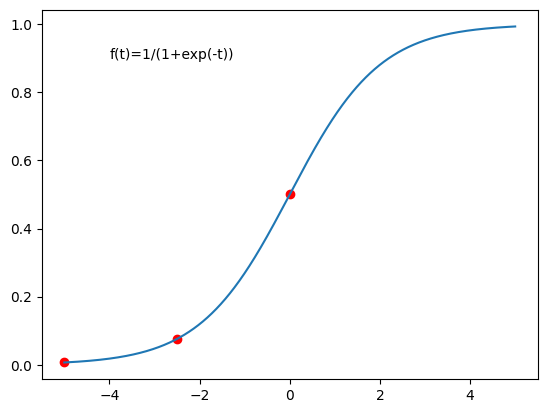

In [18]:
f = lambda t: 1/(1+np.exp(-t))
t = np.linspace(-5,5,1000)

t_half_domain = np.linspace(-5,0,3)
y_half_domain = f(t_half_domain)

plt.plot(t,f(t))
plt.scatter(t_half_domain,y_half_domain, c="r")
plt.text(-4,0.9,"f(t)=1/(1+exp(-t))")

### Design simple Neural Network

In [19]:
class network(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = torch.nn.Linear(1,8)
    self.lin2 = torch.nn.Linear(8,8)
    self.lin3 = torch.nn.Linear(8,8)
    self.lin4 = torch.nn.Linear(8,1)

  def forward(self, t):

    if type(t) != torch.Tensor:
      t=torch.tensor([t]).float()

    t = torch.nn.functional.tanh(self.lin1(t))
    t = torch.nn.functional.tanh(self.lin2(t))
    t = torch.nn.functional.tanh(self.lin3(t))
    return self.lin4(t)

## Build the loss function

compute loss on $M$ sample points in

$\text{physics_informed_loss} = ∑_{i=0}^M(\frac{dnet}{dt_i} - net(t_i)(1-net(t_i)))^2 + (net(0) - 0.5)^2$
\
\
$\text{data_loss} = \sum_{i=0}^N (net(p_i) - y_i)^2$
\
\
$\text{total_loss} = \text{physics_informed_loss + data_loss}$

In [22]:
alpha=1
beta=1
def pinn_loss(dnet, net, y):
  inner = (dnet[0] - y * (1 - y))**2
  boundary = (net(torch.tensor([0.0], requires_grad=True)) - 0.5)**2
  return alpha*inner + beta*boundary

net = network()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1, 0.001, total_iters=1000)
data_Loss = torch.nn.MSELoss()

In [23]:
for epoch in range(1000):
  tt=np.random.uniform(-5,5,32)
  mean_loss = torch.tensor([0.0], requires_grad=True).float()


  for t_i in tt:
    t_i = torch.tensor([t_i], requires_grad=True).float()

    o = net(t_i)

    dnet = torch.autograd.grad(o, t_i, retain_graph=True, create_graph=False)

    intermediate_loss = pinn_loss(dnet, net, o)

    mean_loss = torch.add(mean_loss, intermediate_loss)


  loss_physics = torch.div(mean_loss, 32)

  o_data = net(torch.tensor(t_half_domain.reshape(3,1)).float())

  loss_data = data_Loss(o_data.float().squeeze(), torch.tensor(y_half_domain).float())

  loss = loss_data + loss_physics
  loss.backward()
  optimizer.step()
  lr_scheduler.step()
  optimizer.zero_grad()


  if epoch%10==0:
    print(f"epoch: {epoch} \n\t loss: {mean_loss}")

epoch: 0 
	 loss: tensor([3.6410], grad_fn=<AddBackward0>)
epoch: 10 
	 loss: tensor([0.6483], grad_fn=<AddBackward0>)
epoch: 20 
	 loss: tensor([0.5062], grad_fn=<AddBackward0>)
epoch: 30 
	 loss: tensor([0.1454], grad_fn=<AddBackward0>)
epoch: 40 
	 loss: tensor([0.1278], grad_fn=<AddBackward0>)
epoch: 50 
	 loss: tensor([0.0554], grad_fn=<AddBackward0>)
epoch: 60 
	 loss: tensor([0.0359], grad_fn=<AddBackward0>)
epoch: 70 
	 loss: tensor([0.0226], grad_fn=<AddBackward0>)
epoch: 80 
	 loss: tensor([0.0285], grad_fn=<AddBackward0>)
epoch: 90 
	 loss: tensor([0.0356], grad_fn=<AddBackward0>)
epoch: 100 
	 loss: tensor([0.0093], grad_fn=<AddBackward0>)
epoch: 110 
	 loss: tensor([0.0179], grad_fn=<AddBackward0>)
epoch: 120 
	 loss: tensor([0.0093], grad_fn=<AddBackward0>)
epoch: 130 
	 loss: tensor([0.0103], grad_fn=<AddBackward0>)
epoch: 140 
	 loss: tensor([0.0055], grad_fn=<AddBackward0>)
epoch: 150 
	 loss: tensor([0.0106], grad_fn=<AddBackward0>)
epoch: 160 
	 loss: tensor([0.0025]

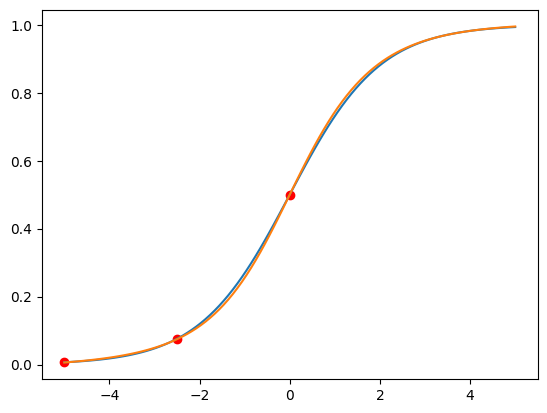

In [24]:
domain = np.linspace(-5,5,100)
plt.plot(domain,f(domain))
plt.plot(domain,net(torch.tensor([domain]).float().reshape(100,1)).detach())
plt.scatter(t_half_domain,y_half_domain, c="r")

In [ ]:
import pysr

/usr/local/lib/python3.10/dist-packages/juliacall/__init__.py:60: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.4 at /root/.julia/environments/pyjuliapkg/pyjuliapkg/install/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()
Detected IPython. Loading juliac

In [ ]:
model = pysr.PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "exp",
        "inv(x) = 1/x",
        "cos"
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [ ]:
X = np.linspace(-5,5,250)
model.fit(X.reshape(250,1), net(torch.tensor(X.reshape(250,1)).float()).detach())

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.380e+04
Head worker occupation: 9.8%
Progress: 188 / 600 total iterations (31.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.606e+00  1.594e+01  y = x₀
2           1.513e-01  3.776e+00  y = exp(-0.69375)
5           7.847e-03  9.864e-01  y = (0.13068 * x₀) + 0.49971
6           1.350e-06  8.668e+00  y = inv(inv(exp(x₀)) + 1.001)
7           1.349e-06  2.110e-05  y = inv(inv(0.99899) + inv(exp(x₀)))
8           1.324e-06  1.896e-02  y = inv(inv(exp(x₀)) + 1.0013) + 0.00025183
11          1.288e-06  9.193e-03  y = (1.2122e-05 * exp(x₀)) + inv(1.0016 + inv(exp(x₀)))
13          1.280e-06  3.107e-03  y = inv(inv(exp(x₀)) + 1.0014) + ((x₀ * exp(x₀)) * 2.3274e-06)
14          1.269e-06  8.485e-03  y = (1.2122e-05 * (exp(x₀) + exp(1.8433))) + inv(1.0016 + inv(...
                                  exp(x₀)))
16          1.267e-06  

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -1.1147418   
	1         2.902830                                    exp(-0.6937474)   
	2         0.986386                     (0.13068497 * x0) + 0.49970806   
	3   >>>>  8.668205                      inv(inv(exp(x0)) + 1.0010184)   
	4         0.000021                 inv(inv(0.9989934) + inv(exp(x0)))   
	5         0.019174      inv(inv(exp(x0)) + 1.0013126) + 0.00023998097   
	6         0.036466    inv(inv(0.99931586) + inv(exp(0.9958196 * x0)))   
	7         0.016856  -0.00026969163 + inv(inv(exp(x0 * 0.9960577)) ...   
	8         0.013552  inv(inv(exp(x0 * 0.9960577)) + inv(exp(-0.0001...   
	9         0.005428  -0.00026969163 + inv(inv(exp(x0 * 0.9960577)) ...   
	10        0.000164  -0.00026969163 + inv(inv(exp(x0 * 0.9960577)) ...   
	11        0.000432  inv(inv(exp(x0)) + 1.001341) + (0.0002518345 *...   
	
	        loss  complexity  
	0   2.757760           1  
	1   0.151312           2  
	2   0.007847           5  
	3   0.000001           6  
	4   0.000001           7  
	5   0.000001           8  
	6   0.000001           9  
	7   0.000001          11  
	8   0.000001          12  
	9   0.000001          15  
	10  0.000001          17  
	11  0.000001          19  
]